In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_recall_curve, classification_report, confusion_matrix,accuracy_score,
                             precision_score, recall_score, f1_score,roc_auc_score, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# Connect to Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')
conect_google= True

Mounted at /content/drive


Loading the data obtained from the questionnaire filled out by the subjects, processing and inserting it into a data frame (df, ipaq_col)

In [5]:
#conect_google=  False
if conect_google== True:
  #path= pd.read_excel('/content/drive/MyDrive/מחקר תזה/gait detection.xlsx')

  path= '/content/drive/MyDrive/מחקר תזה/'
  excelometer_files = '/content/drive/MyDrive/מחקר תזה/CSV file'
else:
  path= 'G:/האחסון שלי/מחקר תזה/'
  excelometer_files = path+'CSV file/'

gait_detection= pd.read_excel(path+'gait detection.xlsx')
selected_columns = ['Subject', 'Age',	'Gender',	'height',	'weight', 'vig', 'mod',	'walk',	'IPAQ-total physical activity',	'IPAQ-time spent sitting',	'BriefBESTest']

df= gait_detection[selected_columns]
df['bmi']= df['weight']/(((df['height'])/100)**2)
df.rename(columns={'IPAQ-total physical activity': 'IPAQ_activity', 'IPAQ-time spent sitting': 'IPAQ_sitting'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 1, 'F': 2})
df['Subject']= df['Subject'].astype(str)


<ipython-input-5-4e3cdba2f6e3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi']= df['weight']/(((df['height'])/100)**2)
<ipython-input-5-4e3cdba2f6e3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'IPAQ-total physical activity': 'IPAQ_activity', 'IPAQ-time spent sitting': 'IPAQ_sitting'}, inplace=True)
<ipython-input-5-4e3cdba2f6e3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

סידור הקבצים מאורי לתיקייה אחת

In [ ]:
# import os
# import shutil

# source_path = path+'data/'
# destination_path = path+'data_new'

# # Ensure the destination directory exists
# if not os.path.exists(destination_path):
#     os.makedirs(destination_path)

# # Loop through all subdirectories in the source path
# for folder_name in os.listdir(source_path):
#     folder_path = os.path.join(source_path, folder_name)

#     # Check if it's a directory
#     if os.path.isdir(folder_path):
#         file_path = os.path.join(folder_path, 'd.csv')

#         # Check if the file exists
#         if os.path.exists(file_path):
#             new_file_path = os.path.join(destination_path, f'{folder_name}.csv')

#             # Copy and rename the file
#             shutil.copy(file_path, new_file_path)
#             print(f'Copied: {file_path} to {new_file_path}')


In [6]:
data_uri= pd.read_excel(path+'ages.xlsx')
data_uri['Subject']= data_uri['Subject'].astype(str)
data_uri['Gender'] = data_uri['Gender'].map({'M': 1, 'F': 2})

folder_path_uri = path+'data_new'
file_paths_uri = [os.path.join(folder_path_uri,"/" +  f) for f in os.listdir(folder_path_uri)]
# Get a list of full file paths in the folder with a forward slash before each file name
if conect_google== True:
  file_paths_uri  = [f[1:-4] for f in file_paths_uri]
else:
  file_paths_uri  = [f[1:-4] for f in file_paths_uri]

data_uri = data_uri[data_uri['Subject'].isin(file_paths_uri)]
data_uri.reset_index(inplace= True)
data_uri.drop('index',axis= 1, inplace= True)


<ipython-input-6-d854faa7c5ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_uri.drop('index',axis= 1, inplace= True)


In [7]:
data_uri= pd.read_excel(path+'ages.xlsx')
data_uri['Subject']= data_uri['Subject'].astype(str)
data_uri['Gender'] = data_uri['Gender'].map({'M': 1, 'F': 2})

folder_path_uri = path+'data_new'
file_paths_uri = [os.path.join(folder_path_uri,"/" +  f) for f in os.listdir(folder_path_uri)]
# Get a list of full file paths in the folder with a forward slash before each file name
if conect_google== True:
  file_paths_uri  = [f[1:-4] for f in file_paths_uri]
else:
  file_paths_uri  = [f[3:-4] for f in file_paths_uri]

data_uri = data_uri[data_uri['Subject'].isin(file_paths_uri)]
data_uri.reset_index(inplace= True)
data_uri.drop('index',axis= 1, inplace= True)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_results(y_true, y_pred, history = None, class_th = 0.5):
    """
    a function to plot model performance

    y_true  : ground truth labels
    y_pred  : predictions made by the model
    history : training and validation loss and accuracy (optional)
    class_th: threshold for classification
    """

    # calculate prediction classes
    y_pred_class = y_pred > class_th

    # calculate precision and recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)

    # print classification report
    print(classification_report(y_true, y_pred_class))

    if history:
        fig, axes = plt.subplots(figsize = (12,7), ncols = 2, nrows = 2)
    else:
        fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

    # plot confusion matrix
    ax = axes.flatten()[0]
    sns.heatmap(confusion_matrix(y_true, y_pred_class), annot = True, ax = ax,cmap='Blues', fmt='g')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')

    # plot individual cases: true labels vs. given probability
    ax = axes.flatten()[1]
    df_result = pd.DataFrame({'True': y_true.flatten(), 'Pred': y_pred.flatten()})
    sns.stripplot(data = df_result, x = 'True', y = 'Pred', ax = ax)
    ax.hlines(class_th, -0.25,1.25, color = 'green', ls = '--')
    ax.set_ylabel('p(X=OLD)')
    ax.set_xlabel('Age')

    # plot train and validation loss and accuracy
    if history:
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        ax = axes.flatten()[2]
        ax.plot(epochs, accuracy, color = 'red', marker = 'o', alpha = 0.7, label="Training accuracy")
        ax.plot(epochs, val_accuracy, color = 'green', marker = 'o', label="Validation accuracy", alpha = 0.8)

        w = int((len(val_accuracy) // 2.5) // 2 * 2 + 1) # savgol_gulary filter window size
        smooth_val_accuracy = signal.savgol_filter(val_accuracy, w, 3)
        ax.plot(epochs, smooth_val_accuracy, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_accuracy, color = 'green', ls = '--', lw = '2')


        ax.set_title("Accuracy")

        ax = axes.flatten()[3]
        ax.plot(epochs, loss, color = 'red', alpha = 0.7, marker = 'o', label="Training")
        ax.plot(epochs, val_loss, color = 'green', marker = 'o', label="Validation", alpha = 0.8)

        smooth_val_loss = signal.savgol_filter(val_loss, w, 3)
        ax.plot(epochs, smooth_val_loss, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_loss, color = 'green', ls = '--', lw = '2')

        ax.set_title("Loss")
        ax.legend(loc = 'best')

    plt.tight_layout()
    plt.show()

def fetch_uri(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = pd.concat([output, temp], ignore_index=True)
            #output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'Axis'] + list(range(freq * n_seconds))]

    return output

    # call the fetch function to read data
n_seconds = 8
newfreq = 100
subjects = data_uri['Subject']
folder = [path+'data_new/'+str(c) for c in subjects.values]

data_uri = fetch_uri(folder,data_uri, freq = newfreq, n_seconds = n_seconds)


#עמודה ראשונה השלמת ערכים חסרים

data_uri.iloc[:, 4] = data_uri.iloc[:, 4].fillna(data_uri.iloc[:, 5])

handcrafted_features = pd.DataFrame()
signal_col = data_uri.iloc[:, 4:]
# Maximum
handcrafted_features['maximum'] = signal_col.max(axis=1)

# Minimum
handcrafted_features['minimum'] =signal_col.min(axis=1)

# Average
handcrafted_features['average'] = signal_col.mean(axis=1)

# Standard deviation
handcrafted_features['std'] = signal_col.std(axis=1)

# Zero crossing
def zero_crossings(values):
    count = 0
    prev_value = values[0]

    # Iterate over the values starting from the second value
    for value in values[1:]:
        # Check if the sign of the current value is different from the previous value
        if prev_value * value < 0:
            count += 1  # Increment the count if there is a zero crossing
        prev_value = value  # Update the previous value for the next iteration

    return count
handcrafted_features['zero_crossings'] = signal_col.apply(zero_crossings, axis=1)

# Percentiles
handcrafted_features['percentile_20'] =signal_col.quantile(0.20, axis=1)
handcrafted_features['percentile_50'] = signal_col.quantile(0.50, axis=1)
handcrafted_features['percentile_80'] = signal_col.quantile(0.80, axis=1)

# Interquartile range
handcrafted_features['interquartile_range'] = signal_col.quantile(0.75, axis=1) - data_uri.iloc[:, 4:804].quantile(0.25, axis=1)

# Kurtosis
handcrafted_features['kurtosis'] = signal_col.kurtosis(axis=1)

# Skewness   𝑠𝑘𝑒𝑤𝑛𝑒𝑠𝑠(𝑀)= 𝜇˜**3= ∑𝑛𝑖=1(𝑚𝑖−𝜇)**3/𝑛𝜎3
handcrafted_features['skewness'] =signal_col.skew(axis=1)

# Order mean values
def order_mean_values(row):
    sorted_row = np.sort(row)  # Sort the row in ascending order
    fom = sorted_row[0]  # First-order statistic (smallest value)
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))  # Reshape som into a 1D array

    # Compute norms
    norm_fom_l1 = np.linalg.norm(sorted_row, ord=1)  # L1 norm of FOM
    norm_fom_l2 = np.linalg.norm(sorted_row, ord=2)  # L2 norm of FOM
    norm_som_l1 = np.linalg.norm(som, ord=1)  # L1 norm of SOM
    norm_som_l2 = np.linalg.norm(som, ord=2)  # L2 norm of SOM
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))[0]
    return [fom, som, norm_fom_l1, norm_fom_l2, norm_som_l1, norm_som_l2]

handcrafted_features[['FOM', 'SOM', 'Norm_FOM_L1', 'Norm_FOM_L2', 'Norm_SOM_L1', 'Norm_SOM_L2']] = signal_col.apply(order_mean_values, axis=1, result_type='expand')

# Spectral entropy  &  Spectral energy:
def spectral_features(row):
    fft_values = np.fft.fft(row) # Compute the Fourier transform
    power_spectrum = np.abs(fft_values) ** 2  # Compute the power spectrum
    normalized_power = power_spectrum / np.sum(power_spectrum)  # Normalize the power distribution
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power)) # Compute Shannon entropy
    spectral_energy = np.sum(power_spectrum)    # Compute the Spectral Energ
    return [spectral_energy, spectral_entropy]

handcrafted_features[['Spectral_Energy', 'Spectral_Entropy']] = signal_col.apply(spectral_features, axis=1, result_type='expand')

# Auto-correlation 𝑅𝑘=  (∑𝑛−𝑘𝑖=1(𝑚𝑖−𝜇)(𝑚𝑖+𝑘−𝜇))/(∑𝑛𝑖=1(𝑚𝑖−𝜇)2)
def auto_correlation(data):
    # Select the columns of interest (columns 6 onwards)
    # Convert the DataFrame to a numpy array, handle missing values, and ensure numeric values
    signal_values = data.to_numpy(dtype=float)  # Convert to numpy array
    signal_values[np.isnan(signal_values)] = 0  # Handle missing values by replacing with 0

    # Compute auto-correlation for each row in the DataFrame
    auto_corr_values = []
    for row in signal_values:
        auto_corr = np.correlate(row, row, mode='full')
        positive_auto_corr = auto_corr[len(row) - 1:]  # Extract positive auto-correlation values
        auto_corr_values.append(positive_auto_corr)
    return auto_corr_values
auto_corr_values = auto_correlation(signal_col)
auto_corr_df = pd.DataFrame(auto_corr_values, columns=[f'auto_corr_{i}' for i in range(len(auto_corr_values[0]))])

base_feature= data_uri.loc[:,['Subject', 'Age','Gender']]
# Concatenate handcrafted features with the existing DataFrame
data = pd.concat([data_uri , auto_corr_df, handcrafted_features], axis=1)




# def moving_average(x, w=20):
#     return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype=np.float64),
#                   (0, w), mode='constant')

# signal_data = data_uri.iloc[:, 4:804]
# # we generate numpy arrays (train, validation and test) for both X and y
# n = int(n_seconds * newfreq)

# ageThreshold = 45
# y = data_uri.loc[np.arange(0, len(data_uri), 4), 'Age'].values
# y = (y > ageThreshold).astype(int).reshape(-1, 1)

# #X = data[np.arange(n)].values.reshape(-1, 4, n)  # Adjusted to 4 axes
# X = signal_data.values.reshape(-1, 4, n)  # Adjusted to 4 axes
# X = np.transpose(X, [0, 2, 1])

# Xt = np.zeros((X.shape[0], 4, X.shape[1], 49))  # Adjusted to 4 axes

# # filtering using low-pass butterworth
# for x in trange(X.shape[0]):
#     for i in range(4):  # Adjusted to 4 axes
#         X[x][:, i] = signal.detrend(X[x][:, i])
#         X[x][:, i] = moving_average(X[x][:, i])
#         Xt[x][i] = np.abs(signal.cwt(X[x][:, i], wavelet=signal.morlet2, widths=np.arange(1, 50)).T)

# X = Xt

# plt.imshow(X[0].T)
# plt.title(str(X.shape))

# X = X.transpose(0, 2, 3, 1)
# print(X.shape)

# # prepare the data set
# batch_size = 32

# # defining classes as categorical
# print(f"True label: {y.mean() * 100:.1f}%")



  0%|          | 0/170 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: in

Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/21: 10.707


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: in

Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/83: 10.657971
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/84: 8.884408
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/102: 11.751869916915894
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/156: 10.566492


In [41]:
data=data_uri[data_uri['Axis']!='t']
# data=data_uri


In [42]:
import numpy as np
from scipy import signal
from tqdm import tqdm

def apply_preprocessing_and_cwt(X, widths=np.arange(1, 50), window_size=20):
    """
    Apply detrending, moving average, and Continuous Wavelet Transform (CWT) to the signal data.
    """
    samples, axes, timesteps = X.shape
    features = len(widths)
    # Adjust Xt shape considering moving average reduces dimension by window_size-1
    new_timesteps = max(timesteps - window_size + 1, 1)
    Xt = np.zeros((samples, axes, new_timesteps, features))

    for sample in tqdm(range(samples)):
        for axis in range(axes):
            # Detrending
            detrended_data = signal.detrend(X[sample, axis, :])

            # Moving average
            if window_size > 1:
                # Ensure the window doesn't exceed the signal length
                valid_window_size = min(window_size, len(detrended_data))
                moving_avg = np.convolve(detrended_data, np.ones(valid_window_size) / valid_window_size, mode='valid')
            else:
                moving_avg = detrended_data

            # Apply CWT on the preprocessed signal
            for i, width in enumerate(widths):
                if len(moving_avg) >= width:  # Ensure sufficient length for the specified width
                    cwt_matrix = signal.cwt(moving_avg, signal.ricker, [width])
                    # Store the absolute values of the CWT coefficients
                    Xt[sample, axis, :, i] = np.abs(cwt_matrix[:new_timesteps])
                else:
                    # If moving_avg is too short, fill with zeros (or consider other handling)
                    Xt[sample, axis, :, i] = 0

    return Xt

# Assuming `n_seconds`, `newfreq`, and `data_uri` are defined correctly
n = int(n_seconds * newfreq)
# X = data_uri.iloc[:, 4:804].values.reshape(-1, 4, n)  # Adjusted to 4 axes
X = data.iloc[:, 4:804].values.reshape(-1, 3, n)  # Adjusted to 4 axes


# Apply preprocessing and CWT to your signal data
Xt = apply_preprocessing_and_cwt(X)

print(f"Original X shape: {X.shape}")
print(f"Transformed Xt shape: {Xt.shape}")

# Continue with your model training using Xt as input

ageThreshold = 45
y = data_uri.loc[np.arange(0, len(data_uri), 4), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1, 1)


100%|██████████| 165/165 [00:07<00:00, 23.40it/s]

Original X shape: (165, 3, 800)
Transformed Xt shape: (165, 3, 781, 49)


In [43]:
# from tensorflow.keras import layers, models, Input

# def init_model(input_shape=(3, 781, 49)):
#     """
#     Initialize a CNN model to handle 4D input.

#     Args:
#     input_shape (tuple): The shape of the input data, excluding the batch size.

#     Returns:
#     keras.models.Model: Compiled CNN model.
#     """
#     inputs = Input(shape=input_shape)
#     # Apply convolutional layers across the timesteps and CWT features
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(inputs)
#     x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(x)
#     x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)

#     model = models.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Initialize the model
# model = init_model()
# model.summary()


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 3, 781, 49)]      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 781, 49)       896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 32, 390, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 390, 24)       18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 64, 195, 12)       0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 149760)            0  

In [46]:
from tensorflow.keras import layers, models, Input, regularizers
import tensorflow as tf

def init_model(input_shape=(3, 781, 49)):
    """
    Initialize a CNN model to handle 4D input with added regularization and dropout for better generalization.
    """
    inputs = Input(shape=input_shape)

    # Apply convolutional layers across the timesteps and CWT features
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      data_format='channels_first',
                      kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      data_format='channels_first',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2), data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(),
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = init_model()
model.summary()


Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 3, 781, 49)]      0         
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 781, 49)       896       
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 32, 390, 24)       0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 32, 390, 24)       96        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 390, 24)       0         
                                                                 
 conv2d_73 (Conv2D)          (None, 64, 390, 24)       184

In [49]:
import tensorflow as tf
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import numpy as np

# Assuming Xt and y have already been defined and preprocessed correctly
epochs = 5
batch_size = 32
k = 5  # Number of folds

# Data and model configuration
k_fold = KFold(n_splits=k, shuffle=True)

# Dictionaries to store results
results = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

for fold, (train_idx, test_idx) in enumerate(k_fold.split(Xt)):
    print(f"Training on fold {fold+1}...")

    # Creating datasets for training and testing
    train_dataset = tf.data.Dataset.from_tensor_slices((Xt[train_idx], y[train_idx]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((Xt[test_idx], y[test_idx])).batch(batch_size)

    # Initialize the model
    model = init_model(input_shape=(3, 781, 49))

    # Callbacks
    model_path = f"model_fold_{fold}.h5"
    checkpoint = keras_callbacks.ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor="val_loss"
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=epochs // 5,  # Adjusted patience to a reasonable fraction of epochs
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        verbose=0,
        validation_data=test_dataset,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best model and evaluate on the test set
    model.load_weights(model_path)
    predictions = model.predict(test_dataset)
    predictions_binary = (predictions > 0.5).astype(int)

    # Calculating metrics
    y_true = np.array([y for _, y in test_dataset.unbatch()])
    results['k-Fold'].append(fold)
    results['Precision'].append(precision_score(y_true, predictions_binary))
    results['Recall'].append(recall_score(y_true, predictions_binary))
    results['AUROC'].append(roc_auc_score(y_true, predictions))

    precision, recall, _ = precision_recall_curve(y_true, predictions.ravel())
    results['AUCPR'].append(auc(recall, precision))

# Output final results
avg_precision = np.mean(results['Precision'])
avg_recall = np.mean(results['Recall'])
avg_auroc = np.mean(results['AUROC'])
avg_aucpr = np.mean(results['AUCPR'])

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average AUROC: {avg_auroc:.4f}")
print(f"Average AUCPR: {avg_aucpr:.4f}")


Training on fold 1...
2/2 [==============================] - 0s 9ms/step
Training on fold 2...
2/2 [==============================] - 1s 12ms/step
Training on fold 3...
2/2 [==============================] - 0s 9ms/step
Training on fold 4...
2/2 [==============================] - 0s 9ms/step
Training on fold 5...
2/2 [==============================] - 0s 9ms/step
Average Precision: 0.4815
Average Recall: 0.2861
Average AUROC: 0.5344
Average AUCPR: 0.5355


In [47]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf

# Assuming Xt is your transformed data with shape (165, 4, 781, 49) and y is your labels

epochs = 100
batch_size = 32
k = 5  # Number of folds

kf = KFold(n_splits=k, shuffle=True)

# Placeholder for results
results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(Xt)):
    print(f"Training on fold {fold+1}...")

    # Splitting the data for this fold
    X_train, X_test = Xt[train_idx], Xt[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize the model with the correct input shape
    model = init_model(input_shape=(3, 781, 49))

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    checkpoint = ModelCheckpoint(f'model_fold_{fold}.h5', save_best_only=True, monitor='val_loss')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=2  # Set to 1 for a progress bar, 0 for no output
    )

    # Load the best version of the model
    model.load_weights(f'model_fold_{fold}.h5')

    # Evaluate the model
    predictions = model.predict(X_test) > 0.5
    accuracy = accuracy_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, model.predict(X_test))
    results.append((accuracy, auc_roc))

    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

# Display average results
avg_accuracy = np.mean([result[0] for result in results])
avg_auc_roc = np.mean([result[1] for result in results])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUC-ROC: {avg_auc_roc:.4f}")


Training on fold 1...
Epoch 1/100
5/5 - 5s - loss: 31.7945 - accuracy: 0.4242 - val_loss: 19.3871 - val_accuracy: 0.5152 - 5s/epoch - 916ms/step
Epoch 2/100
5/5 - 0s - loss: 10.4229 - accuracy: 0.5379 - val_loss: 22.5039 - val_accuracy: 0.5758 - 287ms/epoch - 57ms/step
Epoch 3/100
5/5 - 3s - loss: 9.5327 - accuracy: 0.7121 - val_loss: 15.9473 - val_accuracy: 0.6061 - 3s/epoch - 683ms/step
Epoch 4/100
5/5 - 0s - loss: 10.5798 - accuracy: 0.7273 - val_loss: 16.4469 - val_accuracy: 0.6667 - 287ms/epoch - 57ms/step
Epoch 5/100
5/5 - 1s - loss: 10.8202 - accuracy: 0.7500 - val_loss: 15.5299 - val_accuracy: 0.6667 - 957ms/epoch - 191ms/step
Epoch 6/100
5/5 - 4s - loss: 10.1848 - accuracy: 0.7273 - val_loss: 12.5900 - val_accuracy: 0.6667 - 4s/epoch - 739ms/step
Epoch 7/100
5/5 - 1s - loss: 10.7595 - accuracy: 0.7879 - val_loss: 12.5196 - val_accuracy: 0.6364 - 1s/epoch - 228ms/step
Epoch 8/100
5/5 - 3s - loss: 9.9933 - accuracy: 0.7273 - val_loss: 12.4412 - val_accuracy: 0.5758 - 3s/epoch - 

In [48]:
results

[(0.6363636363636364, 0.661764705882353),
 (0.5151515151515151, 0.44736842105263164),
 (0.5454545454545454, 0.5294117647058824),
 (0.5151515151515151, 0.5296296296296297),
 (0.42424242424242425, 0.5488721804511278)]

In [14]:
print(X.shape)
print(Xt.shape)
# X.shape- (165, 800, 4)
# Xt.shape- (165, 4, 781, 49)



(165, 4, 800)
(165, 4, 781, 49)


In [ ]:
combined_input.shape[1]

6480

In [ ]:
data.iloc[:, 0:800]

,Subject,Age,Gender,Axis,0,1,2,3,4,5,...,786,787,788,789,790,791,792,793,794,795
0,1,72,2,x,0.9540,0.883205,0.838525,0.838458,0.994138,1.113119,...,0.789212,0.571111,0.215109,0.063396,-0.002373,-0.231614,-0.300374,-0.281514,-0.299953,-0.320457
1,1,72,2,y,-0.1344,-0.337565,-0.469122,-0.628107,-0.828843,-0.982325,...,-1.544861,-1.238983,-0.733232,-0.243907,0.031852,0.622066,1.112103,1.372877,2.066751,2.637787
2,1,72,2,z,1.4765,1.820913,1.731057,1.417543,0.707848,0.236582,...,-1.476203,-1.364243,-1.078622,-1.016286,-1.007719,-0.998149,-0.999774,-0.981441,-0.787484,-0.229081
3,1,72,2,t,1.7630,2.052175,1.980691,1.763511,1.481873,1.503078,...,2.278470,1.930031,1.323829,1.054108,1.017517,1.199344,1.525550,1.712224,2.235575,2.669307
4,4,25,1,x,1.7283,2.408333,1.801672,1.424076,1.867200,2.228065,...,0.181035,0.273512,0.294738,0.411460,0.431744,0.452029,0.150833,-0.093082,-0.236363,-0.254131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,183,70,1,t,0.0420,0.053644,0.107883,0.107947,0.087461,0.093271,...,2.587276,2.725472,3.007435,3.418737,3.675547,3.755188,3.753784,3.550176,2.664139,1.856925
656,184,39,2,x,-0.1773,-0.125575,0.004898,-0.062335,-0.217814,-0.220178,...,0.055202,-0.048704,-0.202532,-0.560861,-0.960298,-0.934477,-0.639973,-0.496279,-0.455238,-0.522494
657,184,39,2,y,0.0803,0.163275,0.292184,0.395463,0.357239,0.229535,...,0.453912,0.686991,1.099379,1.331080,1.431217,1.312881,1.242670,1.219428,1.295484,1.507925
658,184,39,2,z,-0.1264,0.220714,0.468248,0.345876,0.117198,0.076538,...,-0.296519,-0.655749,-0.778702,-0.446539,0.396962,1.528244,2.614931,3.155725,2.694198,1.394538


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf

# Assuming your dataset is Xt with shape (samples, 4, 800, 49) and labels y
X = Xt  # Use the transformed data
#y = your_labels  # Assuming 'your_labels' is your dataset labels

epochs = 100
batch_size = 32
k = 5  # Number of folds

kf = KFold(n_splits=k, shuffle=True)

# Placeholder for results
results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Training on fold {fold+1}...")

    # Splitting the data for this fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize the model
    model = init_model_4D(input_shape=(4, 800, 49))

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    checkpoint = ModelCheckpoint(f'model_fold_{fold}.h5', save_best_only=True, monitor='val_loss')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=2  # Set to 1 for a progress bar, 0 for no output
    )

    # Load the best version of the model
    model.load_weights(f'model_fold_{fold}.h5')

    # Evaluate the model
    predictions = model.predict(X_test) > 0.5
    accuracy = accuracy_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, model.predict(X_test))
    results.append((accuracy, auc_roc))

    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

# Display average results
avg_accuracy = np.mean([result[0] for result in results])
avg_auc_roc = np.mean([result[1] for result in results])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUC-ROC: {avg_auc_roc:.4f}")


Training on fold 1...
Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_20" is incompatible with the layer: expected shape=(None, 4, 800, 49), found shape=(None, 4, 820)


In [ ]:
epochs = 100
batch_size = 32
k = 5  # Number of folds

kf = KFold(n_splits=k, shuffle=True)
results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Training on fold {fold+1}...")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = init_model(input_shape=(4, 1623))
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    checkpoint = ModelCheckpoint(f'model_fold_{fold}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=2
    )

    model.load_weights(f'model_fold_{fold}.h5')
    predictions = model.predict(X_test) > 0.5
    accuracy = accuracy_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, model.predict(X_test))
    results.append((accuracy, auc_roc))
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

# Calculate and print average results
avg_accuracy = np.mean([result[0] for result in results])
avg_auc_roc = np.mean([result[1] for result in results])
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

Training on fold 1...


IndexError: index 165 is out of bounds for axis 0 with size 165

In [ ]:
# Assuming Xt is your preprocessed data with the correct shape (samples, 4, 781, 49)
# And assuming y is your labels

import tensorflow as tf

def create_dataset(X, y, batch_size):
    # Ensure X is shaped correctly as expected by the model
    # No reshaping needed if X is already in the correct shape (samples, 4, 781, 49)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(batch_size)
    return dataset

# Create training and testing datasets
train_dataset = create_dataset(Xt_train, y_train, batch_size)  # Assuming Xt_train and y_train are defined
test_dataset = create_dataset(Xt_test, y_test, batch_size)    # Assuming Xt_test and y_test are defined

# Now, you can train your model
model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)


NameError: name 'Xt_train' is not defined

In [ ]:
epochs = 10
batch_size = 32
k = 5

kf = KFold(n_splits=k, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kf.split(Xt)):
    X_train, X_test = Xt[train_idx], Xt[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Note: No need to reshape or split X_train and X_test further; they're already in the correct shape

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    model = init_model_4D(input_shape=(4, 781, 49))  # Reinitialize model for each fold

    print(f"Training fold {fold+1}/{k}")
    model.fit(train_dataset, epochs=epochs, validation_data=test_dataset,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Add evaluation logic as needed


Training fold 1/5
Epoch 1/10


ValueError: in user code:

    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yitzh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_15" is incompatible with the layer: expected shape=(None, 4, 781, 49), found shape=(None, 4, 800, 49)


In [ ]:
def init_model():

  # Define the input layer for the accelerometer data

  acc_input = keras.Input(shape=X.shape[1:])

  # Split the accelerometer input into 4 tensors, one for each axis
  x = acc_input[:, :, 0]
  y = acc_input[:, :, 1]
  z = acc_input[:, :, 2]
  t = acc_input[:, :, 3]

  x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)
  x = layers.Dense(4, activation = "relu")(x)

  y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)
  y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
  y = layers.Dense(4, activation = "relu")(y)

  z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.BatchNormalization()(z)
  z = layers.Dropout(0.5)(z)
  z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
  z = layers.Dense(4, activation = "relu")(z)

  t = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.BatchNormalization()(t)
  t = layers.Dropout(0.5)(t)
  t = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(t)
  t = layers.Dense(4, activation = "relu")(t)

  # Flatten the processed accelerometer outputs
  acc_flatten = layers.Flatten()(tf.concat([x, y, z, t], axis=1))

  # Define the input layer for the static features
  # static_input = keras.Input(shape=static_features.shape[1:])
  # static_processed = layers.Flatten()(static_input)
  # static_processed = layers.Dense(64, activation="relu")(static_processed)
  # static_processed = layers.Dropout(0.5)(static_processed)
  # # Flatten the static features
  # static_processed = layers.Flatten()(static_processed)

  # Combine the flattened accelerometer outputs and static features

  combined = layers.concatenate([acc_flatten])
  #combined = layers.concatenate([acc_flatten, static_processed])

  # Fully connected layers after concatenation
  outputs = layers.Dense(64, activation='relu')(combined)
  outputs = layers.Dense(1, activation='sigmoid')(outputs)

  # Create the model using the defined inputs and output
  model = keras.Model(inputs=acc_input, outputs=outputs)
  #model = keras.Model(inputs=[acc_input,static_input ], outputs=outputs)

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100,
      decay_rate=0.9)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="binary_crossentropy",
              optimizer = optimizer,
              metrics = [tf.keras.metrics.AUC(curve = 'ROC')]
  )
  return model

# Initialize the model
model = init_model()

# Display model summary
model.summary()

ValueError: Input 0 of layer "conv1d_132" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 4)

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf
import numpy as np
import pandas as pd

# Assuming Xt is your preprocessed data with shape (samples, axes, new_length, features)
# and y are your labels, shaped appropriately
epochs = 300
batch_size = 32  # Assuming a batch size of 32
k = 5

df_result = {
    'k-Fold': [],
    'AUROC': [],
    'AUCPR': [],
    'Recall': [],
    'Precision': []
}

# Preparing the scaled version of Xt for training/testing
# Assume Xt is already scaled or does not require scaling due to its nature of processing
X_scaled = Xt

k_fold = KFold(n_splits=k, shuffle=True)

# for j, (train_idx, test_idx) in enumerate(k_fold.split(X_scaled)):
#     # Selecting the training and testing data
#     X_train = [X_scaled[train_idx, i, :, :] for i in range(X_scaled.shape[1])]
#     X_test = [X_scaled[test_idx, i, :, :] for i in range(X_scaled.shape[1])]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # Creating TensorFlow datasets
#     train_dataset = tf.data.Dataset.from_tensor_slices((tuple(X_train), y_train)).shuffle(buffer_size=1024).batch(batch_size)
#     test_dataset = tf.data.Dataset.from_tensor_slices((tuple(X_test), y_test)).batch(batch_size)

#     # Reinitialize the model for each fold
#     model = init_model()
for j, (train, test) in enumerate(k_fold.split(X)):
    # Prepare the inputs from X to match the expected model input structure
    X_train = [X[train, :, i:i+1] for i in range(4)]  # Splitting X into 4 separate inputs
    X_test = [X[test, :, i:i+1] for i in range(4)]

    # Creating TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((tuple(X_train), y[train])).shuffle(buffer_size=1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((tuple(X_test), y[test])).batch(batch_size)

    model = init_model()
    # Define callbacks
    callbacks = [
        ModelCheckpoint(filepath=f"cnn_fold_{j}.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    # Train the model
    history.append(model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks, verbose=0))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    df_result['k-Fold'].append(j + 1)
    df_result['Precision'].append(precision_score(y_test, y_pred))
    df_result['Recall'].append(recall_score(y_test, y_pred))
    df_result['AUROC'].append(roc_auc_score(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

# Convert results to a DataFrame
results_df = pd.DataFrame(df_result)


0epoch [00:00, ?epoch/s]

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import pandas as pd

# Assuming epochs, batch_size, and other necessary variables are defined
epochs = 300
k = 5
history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    # Initialize the scaler
    scaler = StandardScaler()

    # Reshape X for scaling: combine the first two dimensions to treat each feature independently
    num_samples, num_timesteps, num_features = X.shape
    X_reshaped = X.reshape(-1, num_features)  # Shape becomes (165 * 800, 4)

    # Scale the data
    X_scaled = scaler.fit_transform(X_reshaped)

    # Reshape back to original shape
    X_scaled = X_scaled.reshape(num_samples, num_timesteps, num_features)

    scaler = StandardScaler()

    # Fit and transform the scaler on the training data
    X_train_scaled = np.copy(X)
    X_train_scaled[train] = scaler.fit_transform(X[train].reshape(-1, X.shape[2]*X.shape[3])).reshape(-1, X.shape[1], X.shape[2], X.shape[3])

    # Transform the testing data based on the scaler fitted to the training data
    X_test_scaled = np.copy(X)
    X_test_scaled[test] = scaler.transform(X[test].reshape(-1, X.shape[2]*X.shape[3])).reshape(-1, X.shape[1], X.shape[2], X.shape[3])

    # Prepare datasets for both X and static_features with the normalized data
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled[train], y[train]))
    #train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_scaled[train], static_features[train]), y[train]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled[test], y[test]))
    #test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_scaled[test], static_features[test]), y[test]))
    test_dataset = test_dataset.batch(batch_size)

    model = init_model()  # Ensure your model is ready to handle the input shape

    callbacks = [
        ModelCheckpoint(filepath="cnn.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", min_delta=0, patience=epochs // 25, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    history.append(model.fit(train_dataset, epochs=epochs, verbose=0, validation_data=test_dataset, callbacks=callbacks))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

results_df = pd.DataFrame(df_result)


IndexError: tuple index out of range

In [ ]:
results_df



,k-Fold,AUROC,AUCPR,Recall,Precision
0,0,0.520677,0.728469,0.684211,0.590909
1,1,0.592105,0.625291,0.500000,0.538462
2,2,0.577381,0.586174,0.583333,0.437500
3,3,0.488889,0.640404,0.444444,0.533333
4,4,0.454044,0.606952,0.470588,0.470588


Completing missing values by the next value of the sample

# Functios for Uri's data

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_results(y_true, y_pred, history = None, class_th = 0.5):
    """
    a function to plot model performance

    y_true  : ground truth labels
    y_pred  : predictions made by the model
    history : training and validation loss and accuracy (optional)
    class_th: threshold for classification
    """

    # calculate prediction classes
    y_pred_class = y_pred > class_th

    # calculate precision and recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)

    # print classification report
    print(classification_report(y_true, y_pred_class))

    if history:
        fig, axes = plt.subplots(figsize = (12,7), ncols = 2, nrows = 2)
    else:
        fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

    # plot confusion matrix
    ax = axes.flatten()[0]
    sns.heatmap(confusion_matrix(y_true, y_pred_class), annot = True, ax = ax,cmap='Blues', fmt='g')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')

    # plot individual cases: true labels vs. given probability
    ax = axes.flatten()[1]
    df_result = pd.DataFrame({'True': y_true.flatten(), 'Pred': y_pred.flatten()})
    sns.stripplot(data = df_result, x = 'True', y = 'Pred', ax = ax)
    ax.hlines(class_th, -0.25,1.25, color = 'green', ls = '--')
    ax.set_ylabel('p(X=OLD)')
    ax.set_xlabel('Age')

    # plot train and validation loss and accuracy
    if history:
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        ax = axes.flatten()[2]
        ax.plot(epochs, accuracy, color = 'red', marker = 'o', alpha = 0.7, label="Training accuracy")
        ax.plot(epochs, val_accuracy, color = 'green', marker = 'o', label="Validation accuracy", alpha = 0.8)

        w = int((len(val_accuracy) // 2.5) // 2 * 2 + 1) # savgol_gulary filter window size
        smooth_val_accuracy = signal.savgol_filter(val_accuracy, w, 3)
        ax.plot(epochs, smooth_val_accuracy, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_accuracy, color = 'green', ls = '--', lw = '2')


        ax.set_title("Accuracy")

        ax = axes.flatten()[3]
        ax.plot(epochs, loss, color = 'red', alpha = 0.7, marker = 'o', label="Training")
        ax.plot(epochs, val_loss, color = 'green', marker = 'o', label="Validation", alpha = 0.8)

        smooth_val_loss = signal.savgol_filter(val_loss, w, 3)
        ax.plot(epochs, smooth_val_loss, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_loss, color = 'green', ls = '--', lw = '2')

        ax.set_title("Loss")
        ax.legend(loc = 'best')

    plt.tight_layout()
    plt.show()

def fetch_uri(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'Axis'] + list(range(freq * n_seconds))]

    return output

    # call the fetch function to read data
n_seconds = 8
newfreq = 100
subjects = data_uri['Subject']
folder = [path+'data_new/'+str(c) for c in subjects.values]

data_uri = fetch_uri(folder,data_uri, freq = newfreq, n_seconds = n_seconds)

  0%|          | 0/170 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: in

Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/21: 10.707


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: in

Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/83: 10.657971
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/84: 8.884408
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/102: 11.751869916915894
Too short dataset /content/drive/MyDrive/מחקר תזה/data_new/156: 10.566492


In [ ]:
data_uri.iloc[:, 4] = data_uri.iloc[:, 4].fillna(data_uri.iloc[:, 5])

handcrafted_features = pd.DataFrame()
signal_col = data_uri.iloc[:, 4:]
# Maximum
handcrafted_features['maximum'] = signal_col.max(axis=1)

# Minimum
handcrafted_features['minimum'] =signal_col.min(axis=1)

# Average
handcrafted_features['average'] = signal_col.mean(axis=1)

# Standard deviation
handcrafted_features['std'] = signal_col.std(axis=1)

# Zero crossing
def zero_crossings(values):
    count = 0
    prev_value = values[0]

    # Iterate over the values starting from the second value
    for value in values[1:]:
        # Check if the sign of the current value is different from the previous value
        if prev_value * value < 0:
            count += 1  # Increment the count if there is a zero crossing
        prev_value = value  # Update the previous value for the next iteration

    return count
handcrafted_features['zero_crossings'] = signal_col.apply(zero_crossings, axis=1)

# Percentiles
handcrafted_features['percentile_20'] =signal_col.quantile(0.20, axis=1)
handcrafted_features['percentile_50'] = signal_col.quantile(0.50, axis=1)
handcrafted_features['percentile_80'] = signal_col.quantile(0.80, axis=1)

# Interquartile range
handcrafted_features['interquartile_range'] = signal_col.quantile(0.75, axis=1) - data_uri.iloc[:, 4:804].quantile(0.25, axis=1)

# Kurtosis
handcrafted_features['kurtosis'] = signal_col.kurtosis(axis=1)

# Skewness   𝑠𝑘𝑒𝑤𝑛𝑒𝑠𝑠(𝑀)= 𝜇˜**3= ∑𝑛𝑖=1(𝑚𝑖−𝜇)**3/𝑛𝜎3
handcrafted_features['skewness'] =signal_col.skew(axis=1)

# Order mean values
def order_mean_values(row):
    sorted_row = np.sort(row)  # Sort the row in ascending order
    fom = sorted_row[0]  # First-order statistic (smallest value)
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))  # Reshape som into a 1D array

    # Compute norms
    norm_fom_l1 = np.linalg.norm(sorted_row, ord=1)  # L1 norm of FOM
    norm_fom_l2 = np.linalg.norm(sorted_row, ord=2)  # L2 norm of FOM
    norm_som_l1 = np.linalg.norm(som, ord=1)  # L1 norm of SOM
    norm_som_l2 = np.linalg.norm(som, ord=2)  # L2 norm of SOM
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))[0]
    return [fom, som, norm_fom_l1, norm_fom_l2, norm_som_l1, norm_som_l2]

handcrafted_features[['FOM', 'SOM', 'Norm_FOM_L1', 'Norm_FOM_L2', 'Norm_SOM_L1', 'Norm_SOM_L2']] = signal_col.apply(order_mean_values, axis=1, result_type='expand')

# Spectral entropy  &  Spectral energy:
def spectral_features(row):
    fft_values = np.fft.fft(row) # Compute the Fourier transform
    power_spectrum = np.abs(fft_values) ** 2  # Compute the power spectrum
    normalized_power = power_spectrum / np.sum(power_spectrum)  # Normalize the power distribution
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power)) # Compute Shannon entropy
    spectral_energy = np.sum(power_spectrum)    # Compute the Spectral Energ
    return [spectral_energy, spectral_entropy]

handcrafted_features[['Spectral_Energy', 'Spectral_Entropy']] = signal_col.apply(spectral_features, axis=1, result_type='expand')

# Auto-correlation 𝑅𝑘=  (∑𝑛−𝑘𝑖=1(𝑚𝑖−𝜇)(𝑚𝑖+𝑘−𝜇))/(∑𝑛𝑖=1(𝑚𝑖−𝜇)2)
def auto_correlation(data):
    # Select the columns of interest (columns 6 onwards)
    # Convert the DataFrame to a numpy array, handle missing values, and ensure numeric values
    signal_values = data.to_numpy(dtype=float)  # Convert to numpy array
    signal_values[np.isnan(signal_values)] = 0  # Handle missing values by replacing with 0

    # Compute auto-correlation for each row in the DataFrame
    auto_corr_values = []
    for row in signal_values:
        auto_corr = np.correlate(row, row, mode='full')
        positive_auto_corr = auto_corr[len(row) - 1:]  # Extract positive auto-correlation values
        auto_corr_values.append(positive_auto_corr)
    return auto_corr_values
auto_corr_values = auto_correlation(signal_col)
auto_corr_df = pd.DataFrame(auto_corr_values, columns=[f'auto_corr_{i}' for i in range(len(auto_corr_values[0]))])

base_feature= data_uri.loc[:,['Subject', 'Age','Gender']]
# Concatenate handcrafted features with the existing DataFrame
data = pd.concat([data_uri , auto_corr_df, handcrafted_features], axis=1)

In [ ]:
# # # signal_data = data_uri.iloc[:, 5:804]
data_uri.to_csv(path+"/output.csv", index=False)
# data_uri= pd.read_csv(path+'output.csv')
# data = pd.concat([data_uri , auto_corr_df, handcrafted_features], axis=1)

  0%|          | 0/165 [00:00<?, ?it/s]

(165, 800, 49, 4)
True label: 48.5%


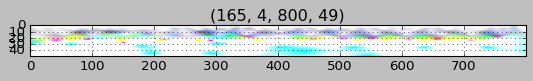

In [ ]:
signal_data = data_uri.iloc[:, 4:804]

def moving_average(x, w=20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype=np.float64),
                  (0, w), mode='constant')

signal_data = data_uri.iloc[:, 4:804]
# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data_uri.loc[np.arange(0, len(data_uri), 4), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1, 1)

#X = data[np.arange(n)].values.reshape(-1, 4, n)  # Adjusted to 4 axes
X = signal_data.values.reshape(-1, 4, n)  # Adjusted to 4 axes
X = np.transpose(X, [0, 2, 1])

Xt = np.zeros((X.shape[0], 4, X.shape[1], 49))  # Adjusted to 4 axes

# filtering using low-pass butterworth
for x in trange(X.shape[0]):
    for i in range(4):  # Adjusted to 4 axes
        X[x][:, i] = signal.detrend(X[x][:, i])
        X[x][:, i] = moving_average(X[x][:, i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:, i], wavelet=signal.morlet2, widths=np.arange(1, 50)).T)

X = Xt

plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0, 2, 3, 1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")


# Functions

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_results(y_true, y_pred, history = None, class_th = 0.5):
    """
    a function to plot model performance

    y_true  : ground truth labels
    y_pred  : predictions made by the model
    history : training and validation loss and accuracy (optional)
    class_th: threshold for classification
    """

    # calculate prediction classes
    y_pred_class = y_pred > class_th

    # calculate precision and recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)

    # print classification report
    print(classification_report(y_true, y_pred_class))

    if history:
        fig, axes = plt.subplots(figsize = (12,7), ncols = 2, nrows = 2)
    else:
        fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

    # plot confusion matrix
    ax = axes.flatten()[0]
    sns.heatmap(confusion_matrix(y_true, y_pred_class), annot = True, ax = ax,cmap='Blues', fmt='g')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')

    # plot individual cases: true labels vs. given probability
    ax = axes.flatten()[1]
    df_result = pd.DataFrame({'True': y_true.flatten(), 'Pred': y_pred.flatten()})
    sns.stripplot(data = df_result, x = 'True', y = 'Pred', ax = ax)
    ax.hlines(class_th, -0.25,1.25, color = 'green', ls = '--')
    ax.set_ylabel('p(X=OLD)')
    ax.set_xlabel('Age')

    # plot train and validation loss and accuracy
    if history:
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        ax = axes.flatten()[2]
        ax.plot(epochs, accuracy, color = 'red', marker = 'o', alpha = 0.7, label="Training accuracy")
        ax.plot(epochs, val_accuracy, color = 'green', marker = 'o', label="Validation accuracy", alpha = 0.8)

        w = int((len(val_accuracy) // 2.5) // 2 * 2 + 1) # savgol_gulary filter window size
        smooth_val_accuracy = signal.savgol_filter(val_accuracy, w, 3)
        ax.plot(epochs, smooth_val_accuracy, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_accuracy, color = 'green', ls = '--', lw = '2')


        ax.set_title("Accuracy")

        ax = axes.flatten()[3]
        ax.plot(epochs, loss, color = 'red', alpha = 0.7, marker = 'o', label="Training")
        ax.plot(epochs, val_loss, color = 'green', marker = 'o', label="Validation", alpha = 0.8)

        smooth_val_loss = signal.savgol_filter(val_loss, w, 3)
        ax.plot(epochs, smooth_val_loss, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_loss, color = 'green', ls = '--', lw = '2')

        ax.set_title("Loss")
        ax.legend(loc = 'best')

    plt.tight_layout()
    plt.show()

def fetch(subjects, df, freq=128, n_seconds=3, train=False):
    """
    A function to read subjects accelerometer data.

    params:
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False

    """

    output = pd.DataFrame()  # output dataframe
    num_index = 0  # Initialize num_index outside the loop
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s + '.csv')
            data.columns = ['time', 'x', 'y', 'z', 't']
        except:
            print(s, ':\t', sys.exc_info()[0])
            continue

        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

        # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()

        data.set_index('time', inplace=True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)
        for c in data.columns:
            y = data[c]
            f = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1, -1))

            temp['Subject'] = df.iloc[num_index]['Subject']
            temp['Axis'] = c
            output = output.append(temp, ignore_index=True)

        num_index += 1  # Increment num_index for each subject

    # Merge with additional information from df
    output = output.merge(df, how='left', on='Subject')

    # Reorder columns
    output = output[['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi', 'Axis'] + list(range(freq * n_seconds))]

    return output

# Reading subjects age data

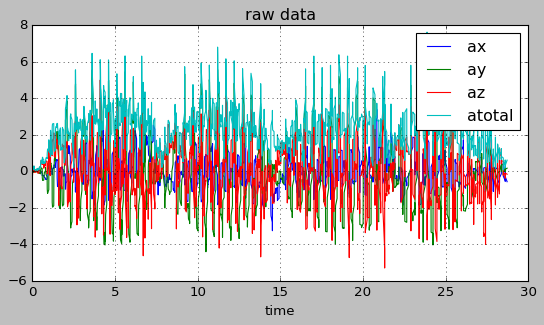

In [ ]:
subjects = df['Subject']
folders = [folder_path+'/'+str(c) for c in subjects.values]
d = pd.read_csv(folders[2]+".csv").set_index('time')
d.iloc[:,:4].plot()
plt.title('raw data');


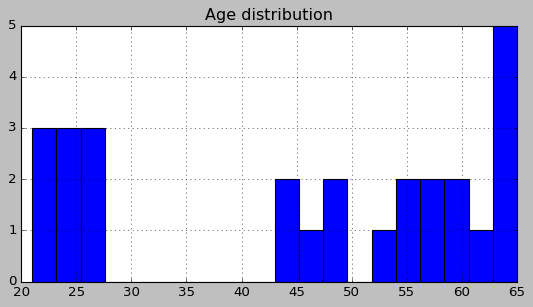

In [ ]:
df['Age'].hist(bins = 20)
plt.title('Age distribution');

In [ ]:
# call the fetch function to read data
n_seconds = 8
newfreq = 100

data = fetch(folders,df, freq = newfreq, n_seconds = n_seconds)


,Subject,Age,Gender,vig,mod,walk,IPAQ_activity,IPAQ_sitting,BriefBESTest,height,...,790,791,792,793,794,795,796,797,798,799
0,1017,55,1,0,0,120,396.0,3780,19,170,...,-2.004609,-1.981167,-1.957724,-1.934281,-1.910839,-1.887396,-1.863953,0.782453,1.016410,1.09
1,1017,55,1,0,0,120,396.0,3780,19,170,...,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-3.390000,-0.022037,0.154391,0.09
2,1017,55,1,0,0,120,396.0,3780,19,170,...,-3.272848,-3.377038,-3.481227,-3.585417,-3.689606,-3.793796,-3.897986,-1.857492,-0.830261,0.20
3,1017,55,1,0,0,120,396.0,3780,19,170,...,5.117709,5.180223,5.242736,5.305250,5.367764,5.430278,5.492791,2.025334,1.349168,1.11
4,1021,45,1,0,0,30,99.0,5040,20,173,...,0.817021,0.829292,0.841563,0.853833,0.866104,0.878374,0.969402,2.167291,2.217808,2.20
5,1021,45,1,0,0,30,99.0,5040,20,173,...,-1.891894,-1.888212,-1.884531,-1.880850,-1.877169,-1.873488,-1.758837,0.744860,0.765754,0.65
6,1021,45,1,0,0,30,99.0,5040,20,173,...,-1.296489,-1.290354,-1.284219,-1.278083,-1.271948,-1.265813,-1.207065,0.043924,-0.003288,-0.03
7,1021,45,1,0,0,30,99.0,5040,20,173,...,2.427298,2.426071,2.424844,2.423617,2.422390,2.421163,2.340598,2.288506,2.343425,2.29


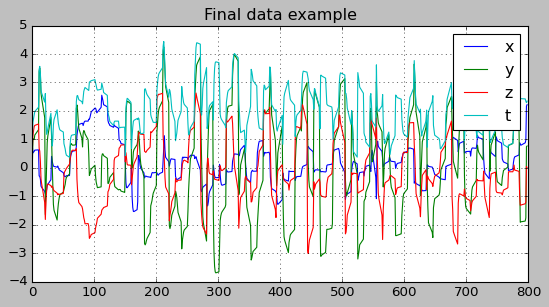

In [ ]:
# we get four lines per subject - representing the accelerometer's x, y,z and T components.
display(data.head(8))

# and we can see an example
d = data[data['Subject'] == subjects[1]]  # Selecting data for the first subject
d.loc[:, np.arange(data.columns[-1])].T.plot()
plt.legend(labels=['x', 'y', 'z', 't'])
plt.title('Final data example')
plt.show()

## Extracting additional features from the accelerometer data

In [ ]:
handcrafted_features = pd.DataFrame()
signal_col = data.iloc[:, 13:]
# Maximum
handcrafted_features['maximum'] = signal_col.max(axis=1)

# Minimum
handcrafted_features['minimum'] =signal_col.min(axis=1)

# Average
handcrafted_features['average'] = signal_col.mean(axis=1)

# Standard deviation
handcrafted_features['std'] = signal_col.std(axis=1)

# Zero crossing
def zero_crossings(values):
    count = 0
    prev_value = values[0]

    # Iterate over the values starting from the second value
    for value in values[1:]:
        # Check if the sign of the current value is different from the previous value
        if prev_value * value < 0:
            count += 1  # Increment the count if there is a zero crossing
        prev_value = value  # Update the previous value for the next iteration

    return count
handcrafted_features['zero_crossings'] = signal_col.apply(zero_crossings, axis=1)

# Percentiles
handcrafted_features['percentile_20'] =signal_col.quantile(0.20, axis=1)
handcrafted_features['percentile_50'] = signal_col.quantile(0.50, axis=1)
handcrafted_features['percentile_80'] = signal_col.quantile(0.80, axis=1)

# Interquartile range
handcrafted_features['interquartile_range'] = signal_col.quantile(0.75, axis=1) - data.iloc[:, 7:807].quantile(0.25, axis=1)

# Kurtosis
handcrafted_features['kurtosis'] = signal_col.kurtosis(axis=1)

# Skewness   𝑠𝑘𝑒𝑤𝑛𝑒𝑠𝑠(𝑀)= 𝜇˜**3= ∑𝑛𝑖=1(𝑚𝑖−𝜇)**3/𝑛𝜎3
handcrafted_features['skewness'] =signal_col.skew(axis=1)

# Order mean values
def order_mean_values(row):
    sorted_row = np.sort(row)  # Sort the row in ascending order
    fom = sorted_row[0]  # First-order statistic (smallest value)
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))  # Reshape som into a 1D array

    # Compute norms
    norm_fom_l1 = np.linalg.norm(sorted_row, ord=1)  # L1 norm of FOM
    norm_fom_l2 = np.linalg.norm(sorted_row, ord=2)  # L2 norm of FOM
    norm_som_l1 = np.linalg.norm(som, ord=1)  # L1 norm of SOM
    norm_som_l2 = np.linalg.norm(som, ord=2)  # L2 norm of SOM
    som = np.mean(sorted_row[:2])  # Second-order statistic (mean of the two smallest values)
    som = np.reshape(som, (1,))[0]
    return [fom, som, norm_fom_l1, norm_fom_l2, norm_som_l1, norm_som_l2]

handcrafted_features[['FOM', 'SOM', 'Norm_FOM_L1', 'Norm_FOM_L2', 'Norm_SOM_L1', 'Norm_SOM_L2']] = signal_col.apply(order_mean_values, axis=1, result_type='expand')

# Spectral entropy  &  Spectral energy:
def spectral_features(row):
    fft_values = np.fft.fft(row) # Compute the Fourier transform
    power_spectrum = np.abs(fft_values) ** 2  # Compute the power spectrum
    normalized_power = power_spectrum / np.sum(power_spectrum)  # Normalize the power distribution
    spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power)) # Compute Shannon entropy
    spectral_energy = np.sum(power_spectrum)    # Compute the Spectral Energ
    return [spectral_energy, spectral_entropy]

handcrafted_features[['Spectral_Energy', 'Spectral_Entropy']] = signal_col.apply(spectral_features, axis=1, result_type='expand')

# Auto-correlation 𝑅𝑘=  (∑𝑛−𝑘𝑖=1(𝑚𝑖−𝜇)(𝑚𝑖+𝑘−𝜇))/(∑𝑛𝑖=1(𝑚𝑖−𝜇)2)
def auto_correlation(data):
    # Select the columns of interest (columns 6 onwards)
    # Convert the DataFrame to a numpy array, handle missing values, and ensure numeric values
    signal_values = data.to_numpy(dtype=float)  # Convert to numpy array
    signal_values[np.isnan(signal_values)] = 0  # Handle missing values by replacing with 0

    # Compute auto-correlation for each row in the DataFrame
    auto_corr_values = []
    for row in signal_values:
        auto_corr = np.correlate(row, row, mode='full')
        positive_auto_corr = auto_corr[len(row) - 1:]  # Extract positive auto-correlation values
        auto_corr_values.append(positive_auto_corr)
    return auto_corr_values
auto_corr_values = auto_correlation(signal_col)
auto_corr_df = pd.DataFrame(auto_corr_values, columns=[f'auto_corr_{i}' for i in range(len(auto_corr_values[0]))])

base_feature= data.loc[:,['Subject', 'Age','Gender', 'vig',	'mod', 'walk',	'IPAQ_activity',	'IPAQ_sitting', 'BriefBESTest', 'height',	'weight', 'bmi']]
# Concatenate handcrafted features with the existing DataFrame
data = pd.concat([data , auto_corr_df, handcrafted_features], axis=1)

  0%|          | 0/165 [00:00<?, ?it/s]

(165, 800, 49, 4)
True label: 48.5%


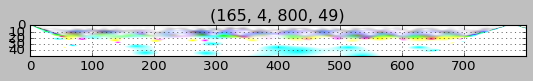

In [ ]:
def moving_average(x, w=20):
    return np.pad(np.array([np.mean(x[i:i+w]) for i in range(x.shape[0] - w)], dtype=np.float64),
                  (0, w), mode='constant')

signal_data = data.iloc[:, 13:813]
# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)

ageThreshold = 45
y = data.loc[np.arange(0, len(data), 4), 'Age'].values
y = (y > ageThreshold).astype(int).reshape(-1, 1)

#X = data[np.arange(n)].values.reshape(-1, 4, n)  # Adjusted to 4 axes
X = signal_data.values.reshape(-1, 4, n)  # Adjusted to 4 axes
X = np.transpose(X, [0, 2, 1])

Xt = np.zeros((X.shape[0], 4, X.shape[1], 49))  # Adjusted to 4 axes

# filtering using low-pass butterworth
for x in trange(X.shape[0]):
    for i in range(4):  # Adjusted to 4 axes
        X[x][:, i] = signal.detrend(X[x][:, i])
        X[x][:, i] = moving_average(X[x][:, i])
        Xt[x][i] = np.abs(signal.cwt(X[x][:, i], wavelet=signal.morlet2, widths=np.arange(1, 50)).T)

X = Xt

plt.imshow(X[0].T)
plt.title(str(X.shape))

X = X.transpose(0, 2, 3, 1)
print(X.shape)

# prepare the data set
batch_size = 32

# defining classes as categorical
print(f"True label: {y.mean() * 100:.1f}%")


דאטה אורי


In [ ]:
data.shape

(660, 1623)

In [ ]:
static_features_data = data.iloc[:, np.r_[2, 804:data.shape[1]]]
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 4

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 4, num_features)
static_features.shape


(165, 4, 820)

In [ ]:
static_features_data = data.iloc[:, np.r_[2:12, 813:data.shape[1]]]
static_features_array = static_features_data.values

# Determine the number of features
num_features = static_features_array.shape[1]

# Calculate the number of subjects based on the number of rows
num_rows = static_features_array.shape[0]
num_subjects = num_rows // 4

# Reshape the data
static_features = static_features_array.reshape(num_subjects, 4, num_features)
static_features.shape

(162, 4, 820)

# building the model

In [ ]:
def init_model():

  # Define the input layer for the accelerometer data
  acc_input = keras.Input(shape=X.shape[1:])

  # Split the accelerometer input into 4 tensors, one for each axis
  x = acc_input[:, :, 0]
  y = acc_input[:, :, 1]
  z = acc_input[:, :, 2]
  t = acc_input[:, :, 3]

  x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)
  x = layers.Dense(4, activation = "relu")(x)

  y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)
  y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
  y = layers.Dense(4, activation = "relu")(y)

  z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.BatchNormalization()(z)
  z = layers.Dropout(0.5)(z)
  z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
  z = layers.Dense(4, activation = "relu")(z)

  t = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.BatchNormalization()(t)
  t = layers.Dropout(0.5)(t)
  t = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(t)
  t = layers.Dense(4, activation = "relu")(t)

  # Flatten the processed accelerometer outputs
  acc_flatten = layers.Flatten()(tf.concat([x, y, z, t], axis=1))

  # Define the input layer for the static features
  static_input = keras.Input(shape=static_features.shape[1:])
  static_processed = layers.Flatten()(static_input)
  static_processed = layers.Dense(64, activation="relu")(static_processed)
  static_processed = layers.Dropout(0.5)(static_processed)
  # Flatten the static features
  static_processed = layers.Flatten()(static_processed)

  # Combine the flattened accelerometer outputs and static features
  combined = layers.concatenate([acc_flatten, static_processed])

  # Fully connected layers after concatenation
  outputs = layers.Dense(64, activation='relu')(combined)
  outputs = layers.Dense(1, activation='sigmoid')(outputs)

  # Create the model using the defined inputs and output
  model = keras.Model(inputs=[acc_input, static_input], outputs=outputs)

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100,
      decay_rate=0.9)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="binary_crossentropy",
              optimizer = optimizer,
              metrics = [tf.keras.metrics.AUC(curve = 'ROC')]
  )
  return model

# Initialize the model
model = init_model()

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 800, 49, 4)]         0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 800, 4)               0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 800, 4)               0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                              

In [ ]:
# model arguments
epochs = 10

history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf

k = 5
k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    # Prepare datasets for both X and static_features
    train_dataset = tf.data.Dataset.from_tensor_slices(((X[train], static_features[train]), y[train]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices(((X[test], static_features[test]), y[test]))
    test_dataset = test_dataset.batch(batch_size=batch_size)

    model = init_model()  # Make sure init_model() now accepts and processes both inputs

    callbacks = [
        ModelCheckpoint(filepath="cnn.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", min_delta=0, patience=epochs // 25, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    history.append(model.fit(train_dataset, epochs=epochs, verbose=0, validation_data=test_dataset, callbacks=callbacks))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

# Convert df_result to a pandas DataFrame for easier handling and visualization
import pandas as pd
results_df = pd.DataFrame(df_result)


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 8ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 8ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 7ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 8ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 9ms/step


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import pandas as pd

# Assuming epochs, batch_size, and other necessary variables are defined
epochs = 10
k = 5
history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit and transform the scaler on the training data
    X_train_scaled = np.copy(X)
    X_train_scaled[train] = scaler.fit_transform(X[train].reshape(-1, X.shape[2]*X.shape[3])).reshape(-1, X.shape[1], X.shape[2], X.shape[3])

    # Transform the testing data based on the scaler fitted to the training data
    X_test_scaled = np.copy(X)
    X_test_scaled[test] = scaler.transform(X[test].reshape(-1, X.shape[2]*X.shape[3])).reshape(-1, X.shape[1], X.shape[2], X.shape[3])

    # Prepare datasets for both X and static_features with the normalized data
    train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_scaled[train], static_features[train]), y[train]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_scaled[test], static_features[test]), y[test]))
    test_dataset = test_dataset.batch(batch_size)

    model = init_model()  # Ensure your model is ready to handle the input shape

    callbacks = [
        ModelCheckpoint(filepath="cnn.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", min_delta=0, patience=epochs // 25, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    history.append(model.fit(train_dataset, epochs=epochs, verbose=0, validation_data=test_dataset, callbacks=callbacks))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

results_df = pd.DataFrame(df_result)


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 9ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 8ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 10ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 10ms/step


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 1s 8ms/step


## נתוני האקסלומטר בלבד

In [ ]:
# model arguments
epochs = 5

history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf

k = 5
k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    # Prepare datasets for both X and static_features
    train_dataset = tf.data.Dataset.from_tensor_slices(((X[train], static_features[train]), y[train]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices(((X[test], static_features[test]), y[test]))
    test_dataset = test_dataset.batch(batch_size=batch_size)

    model = init_model()  # Make sure init_model() now accepts and processes both inputs

    callbacks = [
        ModelCheckpoint(filepath="cnn.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", min_delta=0, patience=epochs // 25, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    history.append(model.fit(train_dataset, epochs=epochs, verbose=0, validation_data=test_dataset, callbacks=callbacks))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

# Convert df_result to a pandas DataFrame for easier handling and visualization
import pandas as pd
results_df = pd.DataFrame(df_result)


ValueError: Input 0 of layer "conv1d_71" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 800)

In [ ]:
def init_model():

  # Define the input layer for the accelerometer data
  acc_input = keras.Input(shape=X.shape[1:])

  # Split the accelerometer input into 4 tensors, one for each axis
  x = acc_input[:, :, 0]
  y = acc_input[:, :, 1]
  z = acc_input[:, :, 2]
  t = acc_input[:, :, 3]

  x = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
  x = layers.MaxPool1D(pool_size = 3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(x)
  x = layers.Dense(4, activation = "relu")(x)

  y = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(y)
  y = layers.MaxPool1D(pool_size = 3)(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)
  y = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(y)
  y = layers.Dense(4, activation = "relu")(y)

  z = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(z)
  z = layers.MaxPool1D(pool_size = 3)(z)
  z = layers.BatchNormalization()(z)
  z = layers.Dropout(0.5)(z)
  z = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(z)
  z = layers.Dense(4, activation = "relu")(z)

  t = layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',kernel_regularizer = 'l2')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(t)
  t = layers.MaxPool1D(pool_size = 3)(t)
  t = layers.BatchNormalization()(t)
  t = layers.Dropout(0.5)(t)
  t = layers.Dense(64, activation = "relu", kernel_initializer=tf.keras.initializers.glorot_normal,kernel_regularizer = 'l2')(t)
  t = layers.Dense(4, activation = "relu")(t)

  # Flatten the processed accelerometer outputs
  acc_flatten = layers.Flatten()(tf.concat([x, y, z, t], axis=1))

  # Define the input layer for the static features
  static_input = keras.Input(shape=static_features.shape[1:])
  static_processed = layers.Flatten()(static_input)
  static_processed = layers.Dense(64, activation="relu")(static_processed)
  static_processed = layers.Dropout(0.5)(static_processed)
  # Flatten the static features
  static_processed = layers.Flatten()(static_processed)

  # Combine the flattened accelerometer outputs and static features
  combined = layers.concatenate([acc_flatten, static_processed])

  # Fully connected layers after concatenation
  outputs = layers.Dense(64, activation='relu')(acc_flatten)
  outputs = layers.Dense(1, activation='sigmoid')(outputs)

  # Create the model using the defined inputs and output
  model = keras.Model(inputs=acc_input, outputs=outputs)

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100,
      decay_rate=0.9)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="binary_crossentropy",
              optimizer = optimizer,
              metrics = [tf.keras.metrics.AUC(curve = 'ROC')]
  )
  return model

# Initialize the model
model = init_model()

# Display model summary
model.summary()

# model arguments
epochs = 5

history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, auc
import tensorflow as tf

k = 5
k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    # Prepare datasets for both X and static_features
    train_dataset = tf.data.Dataset.from_tensor_slices((X[train], y[train]))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((X[test], y[test]))
    test_dataset = test_dataset.batch(batch_size=batch_size)

    model = init_model()  # Make sure init_model() now accepts and processes both inputs

    callbacks = [
        ModelCheckpoint(filepath="cnn.keras", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", min_delta=0, patience=epochs // 25, restore_best_weights=True),
        TqdmCallback(verbose=0)
    ]

    history.append(model.fit(train_dataset, epochs=epochs, verbose=0, validation_data=test_dataset, callbacks=callbacks))

    # Evaluate the model
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))

# Convert df_result to a pandas DataFrame for easier handling and visualization
import pandas as pd
results_df = pd.DataFrame(df_result)


In [ ]:
results_df

## training the model

In [ ]:
# model arguments
epochs = 5

history = []
datasets = []
df_result = {'k-Fold': [], 'AUROC': [], 'AUCPR': [], 'Recall': [], 'Precision': []}

from sklearn.model_selection import KFold, cross_val_score
k = 5
k_fold = KFold(n_splits=k, shuffle=True)
k_fold = k_fold.split(X)

for j, (train, test) in enumerate(k_fold):
    train_dataset = tf.data.Dataset.from_tensor_slices((X[train], y[train]))
    train_dataset = train_dataset.shuffle(buffer_size = batch_size, reshuffle_each_iteration=True).batch(batch_size = batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((X[test], y[test])).batch(batch_size = batch_size)


    model = init_model()

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn.keras",
        save_best_only=True,
        monitor="val_loss"),

    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0,
                                     patience=epochs // 25,
                                     restore_best_weights = True),

    TqdmCallback(verbose=0),]


    history.append(model.fit(train_dataset,
                    epochs = epochs,
                    verbose = 0,
                    validation_data = test_dataset,
                    callbacks = callbacks,
                    shuffle = True
                   ))

    # evaluate
    y_pred = model.predict(test_dataset) > 0.5
    datasets.append(test_dataset)
    df_result['k-Fold'].append(j)
    df_result['Precision'].append(precision_score(y[test], y_pred))
    df_result['Recall'].append(recall_score(y[test], y_pred))
    df_result['AUROC'].append(roc_auc_score(y[test], y_pred))

    precision, recall, _ = precision_recall_curve(y[test], y_pred)
    df_result['AUCPR'].append(auc(recall, precision))



0epoch [00:00, ?epoch/s]

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 800, 49, 4) dtype=float64>]


In [ ]:
df_f = pd.DataFrame(df_result)
df_f = df_f.melt(id_vars = 'k-Fold')
sns.barplot(data = df_f, x = 'k-Fold', y = 'value', hue = 'variable')
plt.hlines(0.5, plt.xlim()[0], plt.xlim()[1], ls = '--', lw = 2, color = 'black')
plt.legend(ncol = 4, title = None, bbox_to_anchor = (1,-.05))



In [ ]:
for i in range (k):

    y_pred = history[i].model.predict(next(iter(datasets[i]))[0])
    y_test = np.array(next(iter(datasets[i]))[1])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aucpr = auc(recall, precision)

    print(f'Model # {i}, AUROC: {roc_auc_score(y_test, y_pred):.3f}, AUCPR: {aucpr:.3f}')
    print('-'*40)
    plot_results(y_test, y_pred)



In [ ]:
import matplotlib.pyplot as plt

# Your data
model_result = [
    ['basic_model_rmsprop', '0.6514285802841187'],
    ['basic_model_adam', '0.7428571581840515'],
    ['augm_model', 0.729],
    ['augm_model', 0.774],
    ['regular_model', '0.8371428847312927'],
    ['VGG16_model', 0.802]
]

# Separate data into model names and values
model_names = []
values = []

for entry in model_result:
    model_names.append(entry[0])
    values.append(float(entry[1]))  # Convert values to float

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values with lines representing the rise
ax.plot(model_names, values, marker='o', linestyle='-')

# Set labels and title
ax.set_xlabel('Model Names')
ax.set_ylabel('Values')
ax.set_title('Rise in Values for Different Models')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
